In [35]:
from IPython.display import display, HTML

display(HTML("""
<h1 style="color: rgb(30, 166, 92); font-size: 48px; font-weight: bold;">
    Building a CNN with NumPy for fun
</h1>
"""))

I will be using the Yoga_82 dataset.

In [ ]:
import os
import requests

def download_yoga82_images(txt_folder="Yoga_82/yoga_dataset_links", save_root="downloaded_yoga_images", max_images=100):

    'Retrieve images, because Yoga_82 website has txt with links'
    
    os.makedirs(save_root, exist_ok=True)
    for txt_file in os.listdir(txt_folder):
        if not txt_file.endswith(".txt"):
            continue
        pose_name = os.path.splitext(txt_file)[0]
        pose_folder = os.path.join(save_root, pose_name)
        os.makedirs(pose_folder, exist_ok=True)
        txt_path = os.path.join(txt_folder, txt_file)
        with open(txt_path, "r", encoding="utf-8") as f:
            for i, line in enumerate(f):
                if i >= max_images:
                    break
                try:
                    if not line.strip():
                        continue
                    relative_path, url = line.strip().split("\t")
                    filename = os.path.basename(relative_path)
                    save_path = os.path.join(pose_folder, filename)

                    if os.path.exists(save_path):
                        continue  
                    response = requests.get(url, timeout=10)
                    if response.status_code == 200:
                        with open(save_path, "wb") as img_file:
                            img_file.write(response.content)
                        print(f"[{pose_name}] {i+1}: Downloaded {filename}")
                    else:
                        print(f"[{pose_name}] {i+1}: Failed with status {response.status_code}")
                except Exception as e:
                    print(f"[{pose_name}] {i+1}: Error - {e}")


download_yoga82_images("Yoga-82/yoga_dataset_links", "downloaded_yoga_images", max_images=30) #I do not have the power to run every image

In [ ]:
import numpy as np
from PIL import Image
import os

def load_yoga82_data(train_file="yoga_train.txt", image_root="downloaded_yoga_images", image_size=(64, 64)):
    X_train = []
    Y_train = []
    with open(train_file, "r", encoding="utf-8") as f:
        for line in f:
            try:
                if not line.strip():
                    continue
                image_rel_path, *labels = line.strip().split(",")
                label = int(labels[0])  # only take the first label  Yoga_82 has three sets of labels (6,20,82) For simplicity I only use the 6 broad classes

                full_image_path = os.path.normpath(os.path.join(image_root, image_rel_path))# Problem with backslashes and not /
                if not os.path.exists(full_image_path):
                    print(f"Missing: {full_image_path}")
                    continue

                
                img = Image.open(full_image_path).convert("L")  # grayscale
                img = img.resize(image_size)  
                img_array = np.array(img) / 255.0  

                X_train.append(img_array)
                Y_train.append(label)

            except Exception as e:
                print(f"Error processing {line.strip()}: {e}")

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)

    print(f"Loaded {len(X_train)} samples.")
    return X_train, Y_train

X_train,Y_train=load_yoga82_data(train_file="Yoga-82/yoga_train.txt",image_root="downloaded_yoga_images",image_size=(128,128))

In [ ]:
np.save('X_train.npy',X_train)
np.save('Y_train.npy',Y_train) #For my sanity
X_train.shape, Y_train.shape

In [ ]:
import numpy as np
X_train=np.load('X_train.npy')
Y_train=np.load('Y_train.npy')

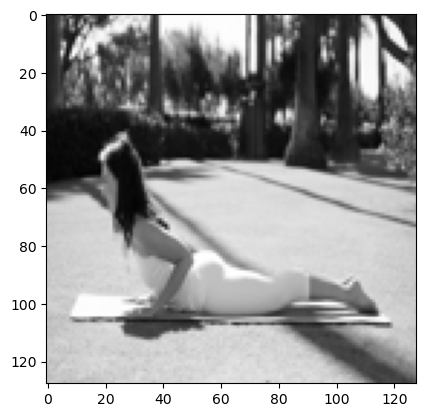

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[156],cmap='gray')

In order to understand convolution one may first apply a fixed filter. Just consider the Prewitt horizontal.

In [ ]:
def fixed_conv(image,filter):
    filter_size=filter.shape[0]
    convolved=np.zeros((image.shape[0]-filter_size+1,image.shape[1]-filter_size+1)) #The size is because at the end of matrix u can't multiply
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            try:
                convolved[i,j]=(image[i:(i+filter_size),j:j+filter_size]*filter).sum()
            except Exception: 
                pass
    convolved=np.maximum(convolved,0)
    return convolved


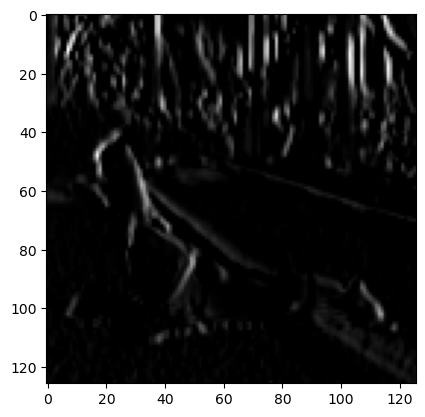

In [ ]:
Prewitt=np.array(([-1,0,1],[-1,0,1],[-1,0,1])) #Horizontal kernel
example=fixed_conv(X_train[156],Prewitt)
plt.imshow(example,cmap='gray')

In [ ]:
from IPython.display import HTML
HTML('''
<h2 style="color:rgb(30, 166, 92); font-weight:bold;">CNN Architecture Overview</h2>
<ul style="color:rgb(30, 166, 92); font-weight:bold; font-size:16px;">
  <li>Input: <code>1 × 128 × 128</code> (grayscale image)</li>
  <li>Conv2D: <code>8 filters, 5×5 kernel</code> + LeakyReLU</li>
  <li>Conv2D: <code>8 filters, 5×5 kernel</code> + LeakyReLU</li>
  <li>MaxPooling: <code>2×2 stride</code></li>
  <li>Conv2D: <code>8 filters, 3×3 kernel</code> + LeakyReLU</li>
  <li>Conv2D: <code>8 filters, 3×3 kernel</code> + LeakyReLU</li>
  <li>Flatten → <code>25088</code></li>
  <li>Dense: <code>25088 → 6</code></li>
  <li>Softmax: Output (<code>6 classes</code>)</li>
</ul>
''')

In [68]:
def init_params():
    kernel_1 = np.random.randn(8, 1, 5, 5) * 0.2       # from 1 input to 8 filters
    kernel_2 = np.random.randn(8, 8, 5, 5) * 0.2       # 8 input 8 output
    kernel_3 = np.random.randn(8, 8, 3, 3) * 0.2
    kernel_4 = np.random.randn(8, 8, 3, 3) * 0.2
    A_1 = np.random.randn(25088, 6) * 0.2
    b_1 = np.random.randn(6)
    return kernel_1, kernel_2, kernel_3, kernel_4, A_1, b_1
def softmax(x):
    if x.ndim==1:
        x = x.reshape(1, -1)
    x=x-np.max(x, axis=1, keepdims=True)
    exp_x=np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
def max_pooling(X,stride=2):
    C,H,W=X.shape
    pooled=np.zeros((C,H//2,W//2))
    for filter in range(C):
        for i in range(0,H,stride):
            for j in range(0,W,stride):
                try:
                    pooled[filter,i//2,j//2]=np.max(X[filter,i:i+stride,j:j+stride])
                except: Exception
                pass
    return pooled
def Leak_Rel_U(X, alpha=0.01):
    return np.where(X > 0, X, alpha * X)
def dLeak_Rel_U(X,alpha=0.01):
    return np.where(X>0,1,alpha)
def back_max_pooling(dout,X,stride=2):
    C,H,W=X.shape
    output=np.zeros_like(X)
    for f in range(C):
        for i in range(0,H,stride):
            for j in range(0,W,stride):
                region=X[f,i:i+stride,j:j+stride]   
                H_out=i//2
                W_out=j//2
                pos=np.unravel_index(np.argmax(region),region.shape)
                output[f,i+pos[0],j+pos[1]]=dout[f,H_out,W_out]
    return output
def multi_channel_convolve(X, kernel):
    C, H, W=X.shape
    F, _, kH, kW=kernel.shape
    out_H=H - kH + 1
    out_W=W - kW + 1
    output=np.zeros((F, out_H, out_W))
    for f in range(F):
        for c in range(C):
            for i in range(out_H):
                for j in range(out_W):
                    region=X[c, i:i+kH, j:j+kW]
                    output[f, i, j]+=np.sum(region * kernel[f, c])
    return output
def multi_channel_convolve_backward(X, kernel, d_out):
    C, H, W=X.shape
    F, _, kH, kW=kernel.shape
    d_kernel=np.zeros_like(kernel)
    d_input=np.zeros_like(X)
    for f in range(F):
        for c in range(C):
            for i in range(kH):
                for j in range(kW):
                    region=X[c, i:i + d_out.shape[1], j:j + d_out.shape[2]]
                    d_kernel[f, c, i, j]=np.sum(region * d_out[f])

        for c in range(C):
            flipped=np.flip(kernel[f, c])
            padded_dout=np.pad(d_out[f], ((kH-1, kH-1), (kW-1, kW-1)), mode='constant')
            for i in range(H):
                for j in range(W):
                    region=padded_dout[i:i+kH, j:j+kW]
                    d_input[c, i, j]+=np.sum(region * flipped)

    return d_kernel, d_input
def forward(kernel_1,kernel_2,kernel_3,kernel_4,A_1,b_1,X):
    L_1=multi_channel_convolve(X,kernel_1)
    R_1=Leak_Rel_U(L_1)
    L_2=multi_channel_convolve(R_1,kernel_2)
    R_2=Leak_Rel_U(L_2)
    R_2_pooled=max_pooling(R_2)
    L_3=multi_channel_convolve(R_2_pooled,kernel_3)
    R_3=Leak_Rel_U(L_3)
    L_4=multi_channel_convolve(R_3,kernel_4)
    R_4=Leak_Rel_U(L_4)
    R_4_flat=R_4.reshape(-1)
    L_5=R_4_flat.dot(A_1)+b_1
    R_5=softmax(L_5)

    return L_1,R_1,L_2,R_2,R_2_pooled,L_3,R_3,L_4,R_4,R_4_flat,L_5,R_5



def backward(L_1,R_1,L_2,R_2,R_2_pooled,L_3,R_3,L_4,R_4,R_4_flat,L_5,R_5,A_1,kernel_1,kernel_2,kernel_3,kernel_4,X,Y):
    label=np.zeros(6)
    label[Y]=1
    dL_5=R_5-label
    dA_1=np.outer(R_4_flat,dL_5)
    db_1=dL_5[0]
    dR_4_flat=dL_5 @ A_1.T
    dR_4=dR_4_flat.reshape(R_4.shape)
    dL_4= dR_4 * dLeak_Rel_U(L_4)
    dk_4,dR_3 = multi_channel_convolve_backward(R_3, kernel_4, dL_4)
    dL_3=dR_3 * dLeak_Rel_U(L_3)
    dk_3,dR_2_pooled = multi_channel_convolve_backward(R_2_pooled, kernel_3, dL_3)
    dR_2=back_max_pooling(dR_2_pooled, R_2)
    dL_2=dR_2 * dLeak_Rel_U(L_2)
    dk_2,dR_1=multi_channel_convolve_backward(R_1, kernel_2, dL_2)
    dL_1=dR_1 * dLeak_Rel_U(L_1)
    dk_1, _=multi_channel_convolve_backward(X, kernel_1, dL_1)    




    
    return dk_1,dk_2,dk_3,dk_4,dA_1,db_1


def train(X,Y,epoch=50,lr=0.01):
    kernel_1,kernel_2,kernel_3,kernel_4,A_1,b_1=init_params()
    N=X.shape[0]
    for iteration in range(epoch):
        indices=np.arange(X.shape[0])
        np.random.shuffle(indices)
        X=X[indices]
        Y=Y[indices]
        dA_1_sum=np.zeros_like(A_1)
        db_1_sum=np.zeros_like(b_1)
        dk_1_sum=np.zeros_like(kernel_1)
        dk_2_sum=np.zeros_like(kernel_2)
        dk_3_sum=np.zeros_like(kernel_3)
        dk_4_sum=np.zeros_like(kernel_4)
        predict=np.zeros_like(Y)
        for i in range(N):
            L_1,R_1,L_2,R_2,R_2_pooled,L_3,R_3,L_4,R_4,R_4_flat,L_5,R_5=forward(kernel_1,kernel_2,kernel_3,kernel_4,A_1,b_1,X[i])
            predict[i] = np.argmax(R_5)
            dk_1,dk_2,dk_3,dk_4,dA_1,db_1=backward(L_1,R_1,L_2,R_2,R_2_pooled,L_3,R_3,L_4,R_4,R_4_flat,L_5,R_5,A_1,kernel_1,kernel_2,kernel_3,kernel_4,X[i],Y[i])
            dA_1_sum+=dA_1
            db_1_sum+=db_1
            dk_1_sum+=dk_1
            dk_2_sum+=dk_2
            dk_3_sum+=dk_3
            dk_4_sum+=dk_4
        dA_1_sum=dA_1_sum/N
        db_1_sum=db_1_sum/N
        dk_1_sum=dk_1_sum/N
        dk_2_sum=dk_2_sum/N
        dk_3_sum=dk_3_sum/N
        dk_4_sum=dk_4_sum/N
        A_1=A_1-lr*dA_1_sum
        b_1=b_1-lr*db_1_sum
        kernel_1=kernel_1-lr*dk_1_sum
        kernel_2=kernel_2-lr*dk_2_sum
        kernel_3=kernel_3-lr*dk_3_sum
        kernel_4=kernel_4-lr*dk_4_sum
        correct=(predict==Y).sum()
        accuracy=correct/N

        print('Predict:',predict)
        print("Accuracy:", accuracy)
    return kernel_1,kernel_2,kernel_3,kernel_4,A_1,b_1

In [60]:
def balance_classes(X_train, Y_train, num_per_class=100): #Due to not including the whole dataset we have balance problems. I already know I have at least 100 of each class Hence the parameter=100
    classes = np.unique(Y_train)
    X_balanced=[]
    Y_balanced=[]
    X_valid=[]
    Y_valid=[]
    for cls in classes:
        idx=np.where(Y_train == cls)[0]
        selected_idx=np.random.choice(idx, size=num_per_class, replace=False)
        non_selected=np.setdiff1d(idx, selected_idx)
        X_balanced.append(X_train[selected_idx])
        Y_balanced.append(Y_train[selected_idx])
        X_valid.append(X_train[non_selected])
        Y_valid.append(Y_train[non_selected])
    X_balanced=np.concatenate(X_balanced,axis=0)
    Y_balanced=np.concatenate(Y_balanced,axis=0)
    X_valid=np.concatenate(X_valid,axis=0)
    Y_valid=np.concatenate(Y_valid,axis=0)
    return X_balanced, Y_balanced, X_valid, Y_valid
X_balanced,Y_balanced,X_valid,Y_valid=balance_classes(X_train,Y_train,100)
X_balanced.shape[0]+X_valid.shape[0]==X_train.shape[0]

True

In [71]:
indices=np.arange(X_balanced.shape[0])
np.random.shuffle(indices)
X_balanced=X_balanced[indices]
Y_balanced=Y_balanced[indices]
prueba=X_balanced[0:4]
prueba=prueba[:,np.newaxis,:,:] #Needed because how I have defined the architecture
train(prueba,Y_balanced[0:4],epoch=15,lr=0.01)


Predict: [4 4 4 4]
Accuracy: 0.0
Predict: [1 1 1 1]
Accuracy: 0.5
Predict: [3 3 3 3]
Accuracy: 0.5
Predict: [3 3 1 3]
Accuracy: 0.75
Predict: [1 3 3 1]
Accuracy: 1.0
Predict: [3 1 3 1]
Accuracy: 1.0
Predict: [1 3 1 3]
Accuracy: 1.0
Predict: [3 1 3 1]
Accuracy: 1.0
Predict: [3 1 1 3]
Accuracy: 1.0
Predict: [3 1 3 1]
Accuracy: 1.0
Predict: [1 3 1 3]
Accuracy: 1.0
Predict: [1 3 3 1]
Accuracy: 1.0
Predict: [1 1 3 3]
Accuracy: 1.0
Predict: [3 3 1 1]
Accuracy: 1.0
Predict: [3 1 3 1]
Accuracy: 1.0


(array([[[[-0.1563134 ,  0.04582794,  0.18256018, -0.02933947,
            0.38033824],
          [ 0.18708603, -0.05905756,  0.04425013,  0.24689106,
           -0.19156817],
          [-0.01357278,  0.5981018 , -0.23534409,  0.20852734,
            0.13681   ],
          [-0.25216438, -0.0779965 , -0.04057107, -0.1528686 ,
           -0.07850377],
          [ 0.10210399,  0.16860555, -0.01171903, -0.2702655 ,
            0.05397946]]],
 
 
        [[[-0.33440392, -0.12219299, -0.09629471, -0.20201683,
           -0.07765649],
          [ 0.10579329, -0.48503601, -0.23274403, -0.16485578,
           -0.2904536 ],
          [-0.37352048, -0.30115612, -0.13914741, -0.0896458 ,
           -0.15206831],
          [-0.02446047, -0.047876  , -0.42025527, -0.19807768,
           -0.16131332],
          [ 0.19131201, -0.18702988, -0.26202624, -0.13377544,
            0.04686607]]],
 
 
        [[[-0.09632302, -0.23188715, -0.38396402,  0.20502361,
           -0.3028774 ],
          [-0.320351

We can overfit a small set. Due to computation problems, I will be implementing my model on PyTorch

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class YogaCNN(nn.Module):
    def __init__(self):
        super(YogaCNN, self).__init__()
        
        self.conv1=nn.Conv2d(1, 8, kernel_size=5)   
        self.conv2=nn.Conv2d(8,8,kernel_size=5)
        self.pool=nn.MaxPool2d(2, 2)              
        self.conv3=nn.Conv2d(8, 8, kernel_size=3)
        self.conv4=nn.Conv2d(8, 8, kernel_size=3)  

        
        self.flattened_size = 8 * 56 * 56  
        
        self.fc1 = nn.Linear(self.flattened_size, 6)

    def forward(self, x):
        x=F.leaky_relu(self.conv1(x))  
        x=self.pool(F.leaky_relu(self.conv2(x)))
        x=F.leaky_relu(self.conv3(x))
        x=F.leaky_relu(self.conv4(x))  
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        return F.log_softmax(x, dim=1)


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=YogaCNN().to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
criterion=nn.NLLLoss()

def train(model, X_train, Y_train,X_valid,Y_valid,epochs=20, batch_size=32):
    model.train()
    dataset=torch.utils.data.TensorDataset(X_train, Y_train)
    loader=torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) 

    for iteration in range(epochs):
        total_loss=0
        correct=0
        correct_valid=0

        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            optimizer.zero_grad()
            output=model(X_batch)
            loss=criterion(output, Y_batch)
            loss.backward()  #Fucking libraries are OP, this was a nightmare.
            optimizer.step()

            total_loss +=loss.item()
            pred=output.argmax(dim=1)
            correct+=(pred==Y_batch).sum().item()
        acc = correct / len(X_train)

        model.eval() #Trying to avoid overfitting my small dataset
        with torch.no_grad():
            X_valid_device=X_valid.to(device)
            Y_valid_device=Y_valid.to(device)
            valid_output=model(X_valid_device)
            valid_pred=valid_output.argmax(dim=1)
            correct_valid=(valid_pred==Y_valid_device).sum().item()
            acc_valid=correct_valid/len(Y_valid)


        print(f"Epoch {iteration+1}: Loss = {total_loss:.4f}, Accuracy on training = {acc:.4f}, Accuracy on valid={acc_valid: .4f}")
        

In [63]:
X_balanced_t=torch.tensor(X_balanced, dtype=torch.float32).unsqueeze(1)
Y_balanced_t=torch.tensor(Y_balanced, dtype=torch.long)
X_valid_t=torch.tensor(X_valid,dtype=torch.float32).unsqueeze(1)
Y_valid_t=torch.tensor(Y_valid,dtype=torch.long)

In [64]:
train(model,X_balanced_t,Y_balanced_t,X_valid_t,Y_valid_t,epochs=15,batch_size=32)

Epoch 1: Loss = 37.1547, Accuracy on training = 0.1483, Accuracy on valid= 0.2622
Epoch 2: Loss = 34.1319, Accuracy on training = 0.1600, Accuracy on valid= 0.3436
Epoch 3: Loss = 33.8195, Accuracy on training = 0.2017, Accuracy on valid= 0.2911
Epoch 4: Loss = 33.7148, Accuracy on training = 0.2417, Accuracy on valid= 0.1935
Epoch 5: Loss = 33.3091, Accuracy on training = 0.2817, Accuracy on valid= 0.2966
Epoch 6: Loss = 32.6804, Accuracy on training = 0.2933, Accuracy on valid= 0.2405
Epoch 7: Loss = 32.0685, Accuracy on training = 0.3183, Accuracy on valid= 0.3165
Epoch 8: Loss = 30.9825, Accuracy on training = 0.3700, Accuracy on valid= 0.1989
Epoch 9: Loss = 30.1454, Accuracy on training = 0.3850, Accuracy on valid= 0.2224
Epoch 10: Loss = 27.6043, Accuracy on training = 0.4633, Accuracy on valid= 0.1483
Epoch 11: Loss = 22.6997, Accuracy on training = 0.5483, Accuracy on valid= 0.2387
Epoch 12: Loss = 15.2793, Accuracy on training = 0.7150, Accuracy on valid= 0.2369
Epoch 13: Los

In [73]:
from IPython.display import display, HTML

display(HTML("""
<h1 style="color: rgb(30, 166, 92); font-size: 24px; font-weight: bold;">
    This results are understandable, I am using only 600 pictures and my architecture is astonishingly simple. However, the initial objetive of understanding the mathematics behind a simple CNN has been a complete success. I would like to remark the absolute lack of formalization behind some of these processes sickens me. However, pretty cool idea and possibilities. 
</h1>
"""))